In [1]:
"""Manual spark configuration based on the default Spark configuration from the NXCALS bundle
and https://gitlab.cern.ch/msobiesz/spark-pipelines/-/blob/master/NXCALS-example-for-DAaaS.ipynb.
Used unless the spark context is already created. (outside of SWAN service or pyspark)
"""

if "spark" not in locals() and "spark" not in globals():
    import os
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession

    nxcals_jars = os.getenv("NXCALS_JARS")
    conf = SparkConf()
    conf.set("spark.master", "yarn")
    conf.set("spark.driver.host", "spark-runner.cern.ch")
    conf.set("spark.driver.port", "5001")
    conf.set("spark.blockManager.port", "5101")
    conf.set("spark.ui.port", "5201")
    conf.set("spark.executorEnv.PYTHONPATH", os.getenv("PYTHONPATH"))
    conf.set("spark.executorEnv.LD_LIBRARY_PATH", os.getenv("LD_LIBRARY_PATH"))
    conf.set("spark.executorEnv.JAVA_HOME", os.getenv("JAVA_HOME"))
    conf.set("spark.executorEnv.SPARK_HOME", os.getenv("SPARK_HOME"))
    conf.set("spark.executorEnv.SPARK_EXTRA_CLASSPATH", os.getenv("SPARK_DIST_CLASSPATH"))
    conf.set("spark.driver.extraClassPath", nxcals_jars)
    conf.set("spark.executor.extraClassPath", nxcals_jars)
    conf.set(
        "spark.driver.extraJavaOptions",
        "-Dservice.url=https://cs-ccr-nxcals5.cern.ch:19093,https://cs-ccr-nxcals5.cern.ch:19094,"
        "https://cs-ccr-nxcals6.cern.ch:19093,https://cs-ccr-nxcals6.cern.ch:19094,"
        "https://cs-ccr-nxcals7.cern.ch:19093,https://cs-ccr-nxcals7.cern.ch:19094,"
        "https://cs-ccr-nxcals8.cern.ch:19093,https://cs-ccr-nxcals8.cern.ch:19094,"
        "https://cs-ccr-nxcalsstr4.cern.ch:19093,https://cs-ccr-nxcalsstr5.cern.ch:19093",
    )

    sc = SparkContext(conf=conf)
    spark = SparkSession(sc)

<h1><center>Analysis of a PLI3.a5 HWC in an RB Circuit</center></h1>
<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/raw/master/figures/rb/RB.png" width=75%>

PLI3.A2 is a simple current cycle at I_INTERM_2 during TIME_INTERM_2, while PLI3.A5 is a current cycle with 2 current levels (I_SM, I_INTERM_2) during TIME_INTERM_2 each. PLI3.A5 can be performed with calorimetric measurement (original purpose). In case of calorimetric measurement, the cryogenic cooling must be stable and maintained constant during the whole cycle. The aim of this test is to check the performance of the current leads and also the splices resistance, and, in case of calorimetric measurements, to detect abnormal heating in the magnets environment.

<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/raw/master/figures/rb/PLI3_current.png" width=50%>

The required analysis and signatures are listed below.

|Responsible|Type of analysis|Criterion|
|-----------|----------------|---------|
|-|Automatic analysis on earth current and error current|I_EARTH_PLI2_S1 < I_EARTH_MAX and I_ERR_PLI2_S1 < I_ERR_MAX|
|MP3|Splice signals|From board A and board B separately R_bus_max <3 nOhm. Individual R_splice_max<0.5nOhm R_mag<50 nOhm|
|MP3|Current lead|46 < TT891A < 54K; Abs(U_RES)< 40mV; and no drift Abs(U_HTS) < 0.5mV|

source: Powering Procedure and Acceptance Criteria for the 13 kA Dipole Circuits, MP3 Procedure, <a href="https://edms.cern.ch/document/874713">https://edms.cern.ch/document/874713</a>

# Analysis Assumptions
- We consider standard analysis scenarios, i.e., all signals can be queried. If a signal is missing, an analysis can raise a warning and continue or an error and abort the analysis.
- It is recommended to execute each cell one after another. However, since the signals are queried prior to analysis, any order of execution is allowed. In case an analysis cell is aborted, the following ones may not be executed (e.g. I\_MEAS not present). 

# Plot Convention
- Scales are labeled with signal name followed by a comma and a unit in square brackets, e.g., I_MEAS, [A].
- If a reference signal is present, it is represented with a dashed line.
- If the main current is present, its axis is on the left. Remaining signals are attached to the axis on the right. The legend of these signals is located on the lower left and upper right, respectively.
- The grid comes from the left axis.
- The title contains timestamp, circuit name, and signal name allowing to re-access the signal.
- The plots assigned to the left scale have colors: blue (C0) and orange (C1). Plots presented on the right have colors red (C2) and green (C3).
- Each plot has an individual time-synchronization mentioned explicitly in the description.
- If an axis has a single signal, then the color of the label matches the signal's color. Otherwise, the label color is black.

# 0. Initialise Working Environment

In [2]:
# External libraries
print("Loading (1/11)")
import sys
import pandas as pd

print("Loading (2/11)")
from IPython.display import display, Javascript, clear_output

# Internal libraries
print("Loading (3/11)")
import lhcsmapi

print("Loading (4/11)")
from lhcsmapi.Time import Time

print("Loading (5/11)")
from lhcsmapi.Timer import Timer

print("Loading (6/11)")
from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery

print("Loading (7/11)")
from lhcsmapi.analysis.RbCircuitAnalysis import RbCircuitAnalysis

print("Loading (8/11)")
from lhcsmapi.analysis.report_template import apply_report_template

print("Loading (9/11)")
from lhcsmapi.gui.hwc.HwcSearchModuleMediator import HwcSearchModuleMediator

print("Loading (10/11)")
from lhcsmapi.pyedsl.PlotBuilder import create_hwc_plot_title_with_circuit_name

print("Loading (11/11)")
from lhcsmapi.analysis.expert_input import get_expert_decision

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

clear_output()
lhcsmapi.get_lhcsmapi_version()
lhcsmapi.get_lhcsmhwc_version("../__init__.py")
print("Analysis performed by %s" % HwcSearchModuleMediator.get_user())

Analysis executed with lhc-sm-api version: 1.5.17
Analysis executed with lhc-sm-hwc notebooks version: 1.5.65
Analysis performed by root


# 1. User Input
1. Copy code from AccTesting and paste into an empty cell below
<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/-/raw/master/figures/swan-manual-acctesting-integration.png">

    - If you only want to test the notebook only for the copy&paste feature (without opening the AccTesting), please copy and execute the code below
    ```
    hwc_test = 'PLI3.a5'
    circuit_name = 'RB.A12'
    campaign = 'HWC_2017'
    t_start = '2017-04-22 08:57:30.399'
    t_end = '2017-04-22 11:32:09.824'
    ```

2. To analyze a historical test with a browser GUI, copy and execute the following code in the cell below
```
circuit_type = 'RB'
hwc_test = 'PLI3.a5'
hwcb = HwcSearchModuleMediator(circuit_type=circuit_type, hwc_test=hwc_test, hwc_summary_path='/eos/project/l/lhcsm/hwc/HWC_Summary.csv')
```

    - After opening the browser GUI, choose a circuit name in order to display HWC test with, campaign name as well as start and end time

In [3]:
# Parameters
hwc_test = "PLI3.a5"
circuit_name = "RB.A12"
campaign = "HWC_2017"
t_start = "2017-04-22 08:57:30.399"
t_end = "2017-04-22 11:32:09.824"
is_automatic = True

In [4]:
print(
    "hwc_test = '%s'\ncircuit_name = '%s'\ncampaign = '%s'\nt_start = '%s'\nt_end = '%s'"
    % (hwc_test, circuit_name, campaign, t_start, t_end)
)

hwc_test = 'PLI3.a5'
circuit_name = 'RB.A12'
campaign = 'HWC_2017'
t_start = '2017-04-22 08:57:30.399'
t_end = '2017-04-22 11:32:09.824'


# 2. Query All Signals Prior to Analysis

In [5]:
circuit_type = "RB"
if "hwcb" in locals():
    circuit_name = hwcb.get_circuit_name()
    t_start = Time.to_unix_timestamp(hwcb.get_start_time())
    t_end = Time.to_unix_timestamp(hwcb.get_end_time())
    is_automatic = hwcb.is_automatic_mode()
else:
    t_start = Time.to_unix_timestamp(t_start)
    t_end = Time.to_unix_timestamp(t_end)
    if "is_automatic" not in locals():
        is_automatic = False

rb_query = RbCircuitQuery(circuit_type, circuit_name, max_executions=6)
rb_analysis = RbCircuitAnalysis(circuit_type, None, is_automatic=is_automatic)

with Timer():
    from lhcsmapi.analysis.busbar.BusbarResistanceAnalysis import MultipleBusbarResistanceAnalysis

    # PC
    i_meas_nxcals_df = rb_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system="PC", signal_names="I_MEAS", spark=spark
    )[0]
    i_meas_raw_nxcals_df = rb_query.query_raw_signal_nxcals(
        t_start, t_end, system="PC", signal_names="I_MEAS", spark=spark
    )[0]
    plateau_start, plateau_end = rb_analysis.find_plateau_start_and_end(
        i_meas_raw_nxcals_df, i_meas_threshold=0, min_duration_in_sec=360, time_shift_in_sec=(240, 60)
    )

    # BUSBAR
    u_res_feature_df, i_meas_feature_df = rb_query.get_busbar_resistances(
        Time.to_unix_timestamp(t_start),
        Time.to_unix_timestamp(t_end),
        plateau_start,
        plateau_end,
        signal_name="U_RES",
        spark=spark,
    )
    res_busbar_row_df = MultipleBusbarResistanceAnalysis.calculate_resistance(
        rb_analysis, i_meas_feature_df, u_res_feature_df, "U_RES", Time.to_unix_timestamp(t_start), circuit_name
    )
    res_busbar_df = rb_analysis.convert_to_col(res_busbar_row_df, signal_name="U_RES")

    # MAGNET
    u_mag_feature_df, i_meas_feature_df = rb_query.get_busbar_resistances(
        Time.to_unix_timestamp(t_start),
        Time.to_unix_timestamp(t_end),
        plateau_start,
        plateau_end,
        signal_name="U_MAG",
        spark=spark,
    )
    res_magnet_row_df = MultipleBusbarResistanceAnalysis.calculate_resistance(
        rb_analysis, i_meas_feature_df, u_mag_feature_df, "U_MAG", Time.to_unix_timestamp(t_start), circuit_name
    )
    res_magnet_df = rb_analysis.convert_to_col(res_magnet_row_df, signal_name="U_MAG")

    # LEADS
    u_res_nxcals_dfs = rb_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system=["LEADS_EVEN", "LEADS_ODD"], signal_names="U_RES", spark=spark
    )
    u_hts_nxcals_dfs = rb_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system=["LEADS_EVEN", "LEADS_ODD"], signal_names="U_HTS", spark=spark
    )

    # DFB
    tt891a_nxcals_dfs = rb_query.query_dfb_signal_nxcals(
        t_start, t_end, system=["LEADS_EVEN_WINCCOA", "LEADS_ODD_WINCCOA"], signal_names="TT891A", spark=spark
    )
    tt893_nxcals_dfs = rb_query.query_dfb_signal_nxcals(
        t_start, t_end, system=["LEADS_EVEN_WINCCOA", "LEADS_ODD_WINCCOA"], signal_names="TT893", spark=spark
    )
    cv891_nxcals_dfs = rb_query.query_dfb_signal_nxcals(
        t_start, t_end, system=["LEADS_EVEN_WINCCOA", "LEADS_ODD_WINCCOA"], signal_names="CV891", spark=spark
    )

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Elapsed: 654.582 s.


# 3. Power Converter
## 3.1. Plot of the Power Converter Main Current

*ANALYSIS*:

- Calculation of the duration of current plateaus

*GRAPHS*:

- t = 0 s corresponds to the start of the test
- Orange box(es) represent period(s) of time with constant current used for calculation of busbar resistance and DFB thresholds

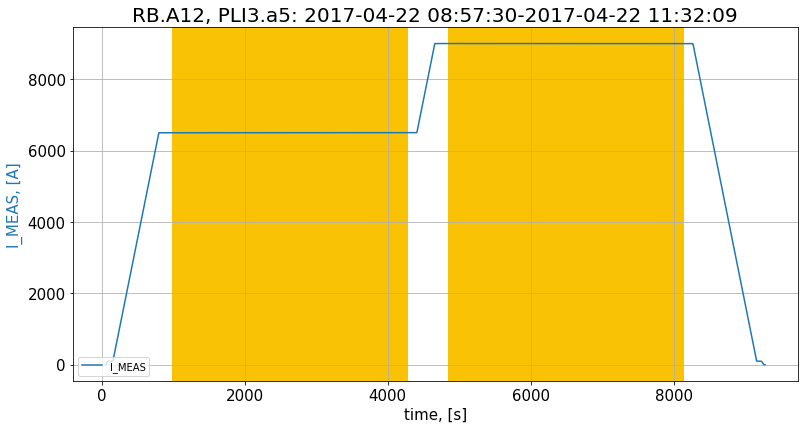

In [6]:
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 80
mpl.rcParams["figure.dpi"] = 80
%matplotlib inline
title = "%s, %s: %s-%s" % (
    circuit_name,
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
rb_analysis.plot_i_meas_with_current_plateau(
    i_meas_nxcals_df,
    t0=i_meas_raw_nxcals_df.index[0],
    plateau_start=plateau_start,
    plateau_end=plateau_end,
    title=title,
)

# 4. Busbar
## 4.1. Busbar Resistance

*ANALYSIS*:

- Calculation of the busbar resistance as the slope of a linear fit of U,I curve obtained from the corresponding mean values of the voltage and current

*CRITERIA*:

- Check if the busbar resistance is below 3 nOhm

*GRAPHS*:

- The busbar resistance, R
- The green box denotes the validity region of the busbar resostance (0, 3] nOhm

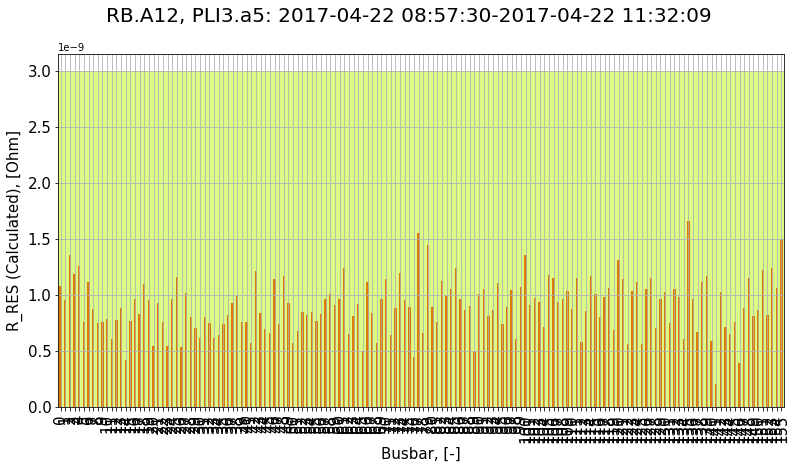

In [7]:
title = "%s, %s: %s-%s" % (
    circuit_name,
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
res_busbar_outliers_df = rb_analysis.analyze_busbar_magnet_resistance(
    res_busbar_df, signal_name="R_RES", value_max=3e-9, title=title
)

In [8]:
RbCircuitQuery.query_and_plot_outlier_voltage(
    res_busbar_outliers_df,
    t_start,
    t_end,
    i_meas_raw_nxcals_df.index[0],
    plateau_start,
    plateau_end,
    is_automatic=is_automatic,
    spark=spark,
)

All resistances within the range.


In [9]:
busbar_metadata_resistance_df = rb_analysis.merge_busbar_metadata_with_resistance(
    res_busbar_df, circuit_type, circuit_name
)
rb_analysis.display_busbar_metadata_resistance_with_threshold(busbar_metadata_resistance_df, threshold=3e-9)

## 4.2. Magnet Resistance

*ANALYSIS*:

- Calculation of the magnet resistance as the slope of a linear fit of U,I curve obtained from the corresponding mean alues of the voltage and current

*CRITERIA*

- Check if the resistance is below 50 nOhm

*GRAPHS*:

- The magnet resistance, R
- The green box denotes the validity region of the magnet resistance (0, 50] nOhm


The following features are outside of range.


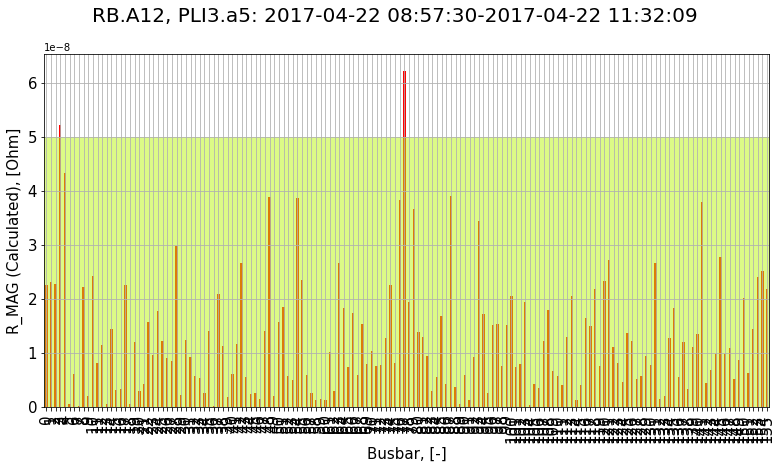

Due to the limited accuracy of the measurement it cannot be excluded that one or more joint resistances in the circuit are larger than 50.000000 nOhm.


In [10]:
title = "%s, %s: %s-%s" % (
    circuit_name,
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
res_magnet_outliers_df = rb_analysis.analyze_busbar_magnet_resistance(
    res_magnet_df, signal_name="R_MAG", value_max=50e-9, title=title
)

Resistance(s) outside of range:


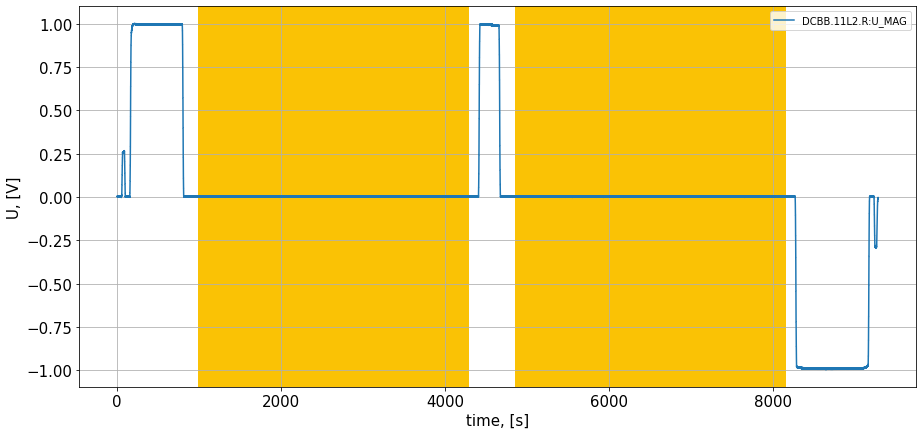

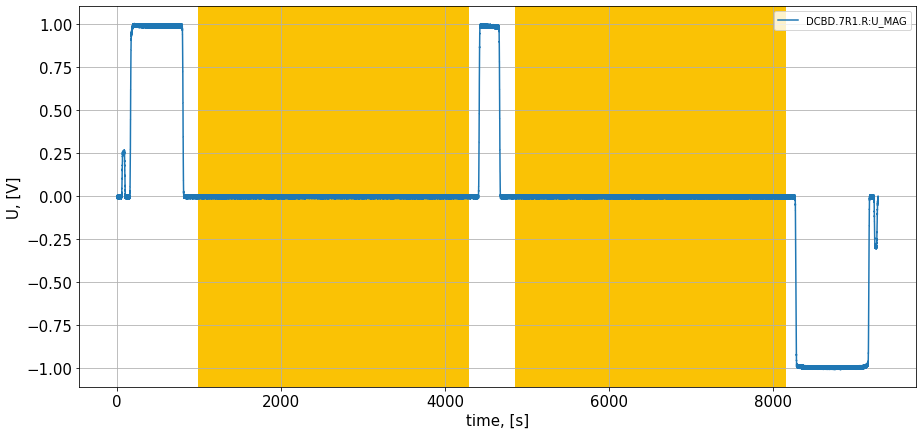

In [11]:
RbCircuitQuery.query_and_plot_outlier_voltage(
    res_magnet_outliers_df.reset_index(),
    t_start,
    t_end,
    i_meas_raw_nxcals_df.index[0],
    plateau_start,
    plateau_end,
    is_automatic=is_automatic,
    spark=spark,
)

In [12]:
magnet_metadata_resistance_df = rb_analysis.merge_busbar_metadata_with_resistance(
    res_magnet_df, circuit_type, circuit_name, res_col="R_MAG"
)
rb_analysis.display_busbar_metadata_resistance_with_threshold(
    magnet_metadata_resistance_df, threshold=50e-9, res_col="R_MAG"
)

# 5. DFB
## 5.1. DFB Voltage - U_RES

*CRITERIA*:
- Check if, at constant current, U_RES is constant (no drift < 2mV/h)

*GRAPHS*:
- t = 0 s corresponds to the start time of the test


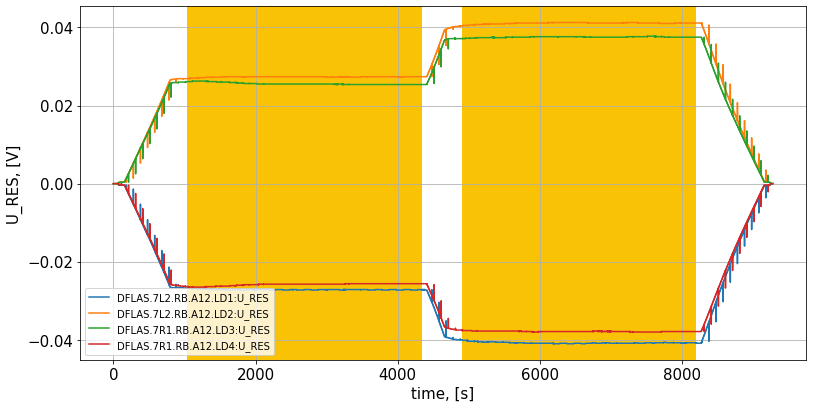

In [13]:
RbCircuitAnalysis.assert_u_res_min_max_slope(
    u_res_nxcals_dfs, plateau_start, plateau_end, Time.to_unix_timestamp(t_start), slope_range=(-2, 2)
)

## 5.2. DFB Voltage - U_HTS

*CRITERIA*:  
- Check if the voltage is below 50% of the threshold -> Abs(U_HTS) < 0.5 mV

*GRAPHS*:
- t = 0 s corresponds to the start time of the test

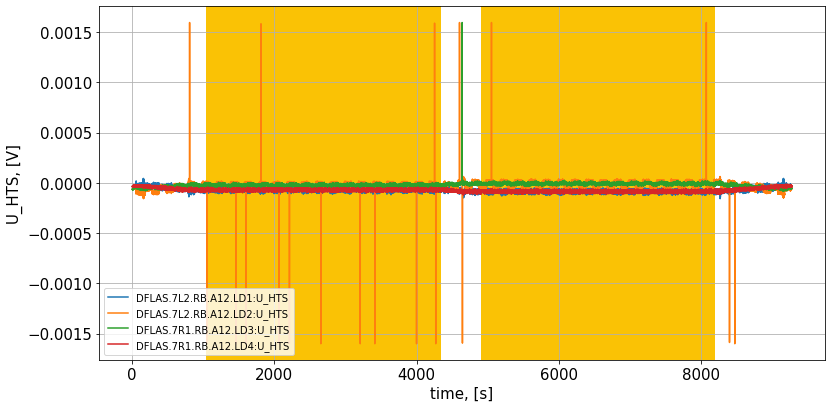

In [14]:
RbCircuitAnalysis.assert_u_hts_min_max_slope(
    u_hts_nxcals_dfs, plateau_start, plateau_end, Time.to_unix_timestamp(t_start), slope_range=(-0.5, 0.5)
)

## 5.3. DFB Temperature - TT893.TEMPERATURECALC

*CRITERIA*:

- Check if the temperature is over the dew point, but not overheated -> 280 K < TT893 < 320 K, even without current

*GRAPHS*:

- Temperature at the top of the current lead on the right axis, TT893.TEMPERATURECALC
- Green box denotes the temperature validity region [280, 320] K of the temperature at the top of the current lead
- t = 0 s corresponds to the start time of the test

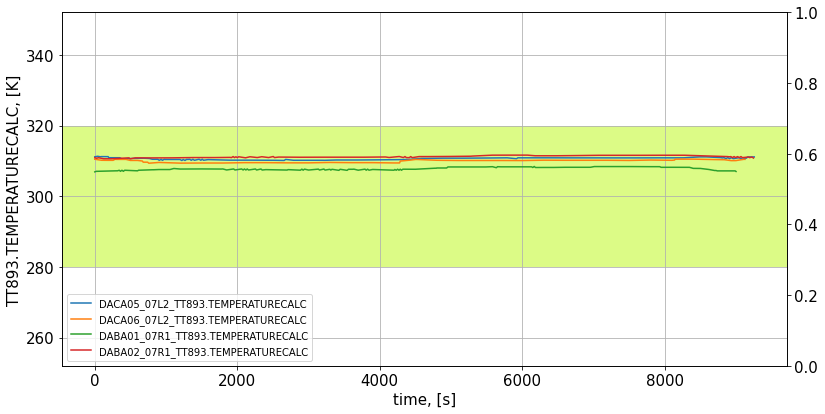

In [15]:
RbCircuitAnalysis.assert_tt893_min_max_value(tt893_nxcals_dfs, value_range=(280, 320))

## 5.4. DFB Temperature - TT891A.TEMPERATURECALC

*CRITERIA*:

- Check if the temperature is regulated around 50 K -> 46 K < TT891A < 54 K, even without current

*GRAPHS*:

For odd and even leads
- Main power converter current, I_MEAS
- Temperature between the HTS and resistive part of the current lead on the right axis, TT891A.TEMPERATURECALC
- t = 0 s corresponds to the start time of the test


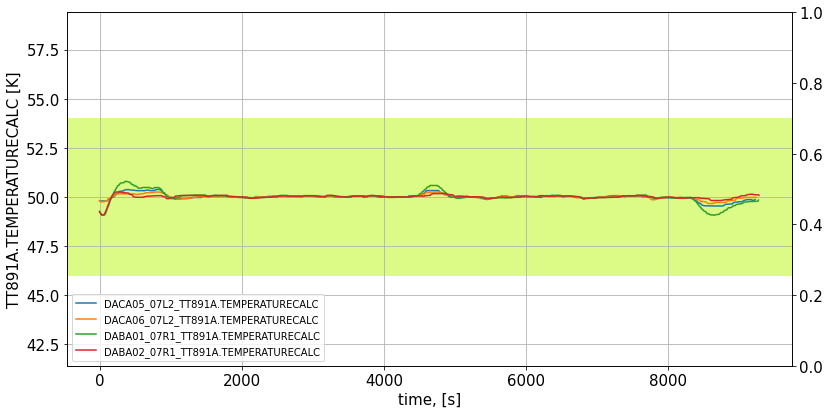

In [16]:
RbCircuitAnalysis.assert_tt891a_min_max_value(tt891a_nxcals_dfs, value_range=(46, 54))

## 5.5. DFB Valve Regulation - CV891.POSST

*CRITERIA*:

- Check if the valve is opened (>2%), but not fully (<50%)
- Check if the valve variation (defined as difference between the maximum and minimum value) does not exceed 8% at constant current (the ramp of the current is excluded this criterion)

*GRAPHS*:

- Main power converter current, I_MEAS
- Valve for regulation of TT891A, CV891.POSST
- t = 0 s corresponds to the start time of the test
- Green box denotes the valve opening validity region [2, 50] % of the TT891A temperature regulation

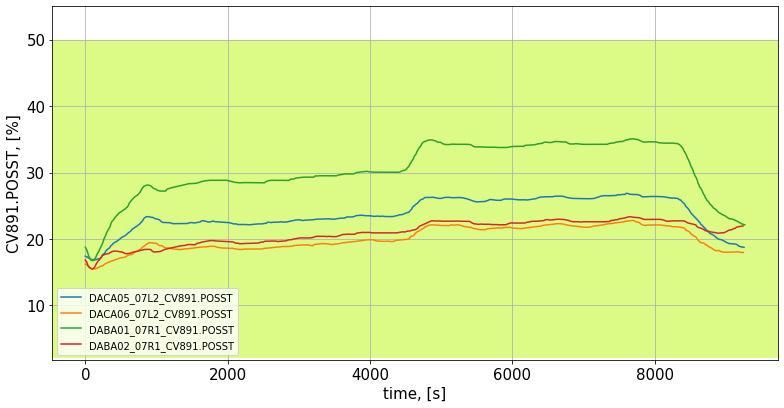

In [17]:
RbCircuitAnalysis.assert_cv891_min_max_value(cv891_nxcals_dfs, value_range=(2, 50))

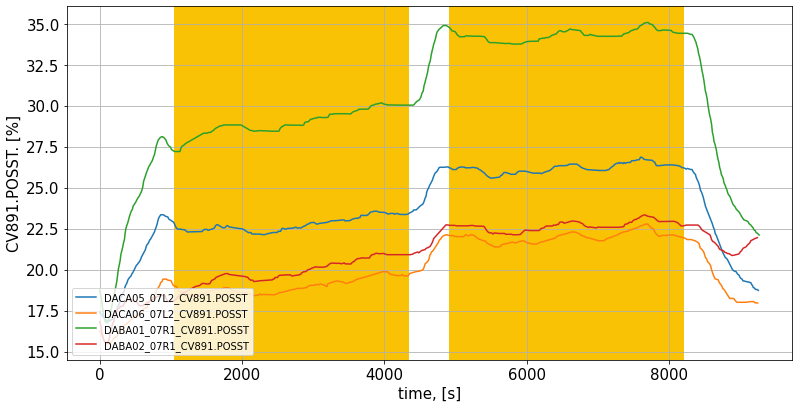

In [18]:
RbCircuitAnalysis.assert_cv891_min_max_variation(
    cv891_nxcals_dfs, 8, plateau_start, plateau_end, Time.to_unix_timestamp(t_start)
)